### Machine Learning I / Lab2 Classification
#### Authors: Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
Data set from: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

# Introduction

Our goal in this lab is to pick the best model for the following two tasks:

1)  Predict if the patient will have high blood pressure based on the variables available in our data.

2)  Predict if a patient would have cardiovascular disease based on the variables available in our data. 


We will be using Logistic Regression, KNN and Random Forest models to accomplish these tasks.   Other attempts were made to run different models with SVM, Logistic Regrssion, KNN, Random Forest, and Decision Trees and we are presenting the top 3 models for each task with the highest performance.




# Data Dictionary

There are 3 types of attributes:

* Objective: factual information
* Examination: results of medical examination
* Subjective: information given by the patient


**age** (Objective):    The age of the patient in days.  Values range from 10798 days (29 years) to 23713 days (about 65 years)

**height** (Objective):   The height of the patient in centimeters

**weight** (Objective):  The weight of the patient in Kilograms

**gender** (Objective):  Categorical code of 1 for woman or 2 for man

**ap_hi** (Examination):  Systolic Blood Pressure   *Integer* 

**ap_lo** (Examination):  Diastolic blood pressure   *Integer*

**cholesterol** (Examination): 1: normal, 2: above normal, 3: well above normal

**gluc**  (Examination):  Glucose  1: normal, 2: above normal, 3: well above normal

**smoke** (Subjective)   Indicator to determine whether patient smokes or not  (binary)

**alco** (Subjective): Indicator to determine if patient drinks alcohol or not (binary)

**active** (Subjective): Indicator to determine if patient is active or not (binary)

**cardio** (Examination):  Target variable to determine if heart disease is present (binary)


<br><b>BMI</b>: Body Mass Index was created, calculated as folows: <b> weight (in kg) / (height(in cm)/100)^2 </b>
<br>
<br><b>bp</b>: Blood pressure will be addressed in the individual modelling sections.


# Setup

### Dependancies

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain

from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import jaccard_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

#load in data
df = pd.read_csv("cardio_train.csv", sep=";")

# Data Preparation

This section is for the data preparation that is not model specific. We removed unreasonable values and created useful variables to be used for both of the two classification tasks. This process included: pre-processing, profiling (see Lab 1), cleansing, validation and transformation (creating new variables).

Each task and each model within the tasks may have more specific individual data preparation sections for their own specific needs.

### Removing Unreasonable Values

Removing invalid values per our Exploratory Data Analysis document

This data has values for weight, height and blood pressure that are not possible for living people. We decided that these were errors and are removing them.

In [2]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

### Calculate BMI (Body Mass Index)

We decided to create a BMI variable using the height and weight, because the BMI is a common variable that is related to heart disease.

In [3]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2


### Drop Useless Variables

Id is not a useful feature in our models, so we drop it.  It is a sequential number that is not relevant for either of our tasks.

In [4]:
df = df.drop('id', axis=1)

# The Final Dataset Used for Classification

Variables in our data are:  gender, systolic blood pressure, diastolic blood pressure, age, height, weight, BMI, a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    


In [5]:
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
5  21914       1     151    67.0    120     80            2     2      0   
6  22113       1     157    93.0    130     80            3     1      0   

   alco  active  cardio        bmi  
1     0       1       1  34.927679  
2     0       0       1  23.507805  
3     0       1       1  28.710479  
5     0       0       0  29.384676  
6     0       1       0  37.729725

There are 53,053 rows in our dataset. All the variables are numeric. All of the variables are integer format with the exception of weight and BMI which are float.  For the purposes of accuracy, we left weight and BMI as float to allow for decimal places.  See chart below for data types. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53053 entries, 1 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          53053 non-null  int64  
 1   gender       53053 non-null  int64  
 2   height       53053 non-null  int64  
 3   weight       53053 non-null  float64
 4   ap_hi        53053 non-null  int64  
 5   ap_lo        53053 non-null  int64  
 6   cholesterol  53053 non-null  int64  
 7   gluc         53053 non-null  int64  
 8   smoke        53053 non-null  int64  
 9   alco         53053 non-null  int64  
 10  active       53053 non-null  int64  
 11  cardio       53053 non-null  int64  
 12  bmi          53053 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 5.7 MB


The ranges, means, and standard deviations of the features are shown from our data profiling analysis here. 

**Continuous variables:** age, height, weight, ap_hi, ap_lo, bmi

**Ordinal/binary variables:** gender, cholesterol, gluc, smoke, alco, active, cardio

In [7]:
df.describe()

age        gender        height        weight         ap_hi  \
count  53053.000000  53053.000000  53053.000000  53053.000000  53053.000000   
mean   19681.817352      1.373739    165.069421     76.417400    131.177294   
std     2394.809551      0.483800      7.683949     13.638346     14.262603   
min    10859.000000      1.000000    131.000000     56.000000    111.000000   
25%    18161.000000      1.000000    160.000000     66.000000    120.000000   
50%    19830.000000      1.000000    165.000000     74.000000    125.000000   
75%    21692.000000      2.000000    170.000000     84.000000    140.000000   
max    23713.000000      2.000000    198.000000    180.000000    197.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  53053.000000  53053.000000  53053.000000  53053.000000  53053.000000   
mean      83.863043      1.397150      1.243247      0.090136      0.055661   
std        7.724346      0.707587      0.592685      0.286380      0.229269   
min       61.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      140.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio           bmi  
count  53053.000000  53053.000000  53053.000000  
mean       0.799974      0.558819     28.120037  
std        0.400024      0.496533      5.133171  
min        0.000000      0.000000     14.577259  
25%        1.000000      0.000000     24.337480  
50%        1.000000      1.000000     26.989619  
75%        1.000000      1.000000     30.846277  
max        1.000000      1.000000     85.779743

# Task 1: Predicting Normal/High/Very High Blood Pressure 

## Evaluation Metrics


We decided to choose F1 score as our main metric because it is a balance between the precision and recall.  Recall is critical because we don't want to miss a patient who has high blood pressure.  Precision is important because we don't want to over call patient with high blood pressure when they don't have it. We decided to use F1 score because our outcome is classification. This F1 score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but for our purpose F1 is more useful than accuracy. Accuracy works best if false positives and false negatives have similar implication for the patient. If the implication of false positives and false negatives are very different, it’s better to look at both Precision and Recall. We will have to put some effort into translating the F1 score into a non-statistical language that our client can understand.

## Blood Pressure Target Categories

In our EDA we classified blood pressure according to the American Heart Association in 5 levels.   This made the data categories very imbalanced for all the 5 levels of blood pressure. Therefore, we decided to use a 3 level classification of blood pressure, based on common practice. Even though this is not the official classification from the American Heart Association, it is very often used in practice. 

1= Normal Blood Pressure <br>
2= High Blood Pressure <br>
3= Very High Blood Pressure

In [5]:


# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3'])

# Make a 3 way clasification
df['bp2'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), "a", df.bp)
df['bp2'] = np.where((df.ap_hi >= 120) & (df.ap_hi <= 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), "b", df.bp2)
df['bp2'] = np.where((df.ap_hi > 140) | (df.ap_lo >= 90), "c", df.bp2)


### Blood Pressure Count Distribution

We classified 3 levels of blood pressure.  Category "a" is normal blood pressure.  Catgory "b" is high blood pressure and category "c" is very high blood pressure.  Even with 3 categories of blood pressure, we still had issues with imbalanced data.  It is not as imbalanced as it was with 5 categories, but we still had to account for it.  The normal blood pressure level category has a low number of samples in comparison to the other 2 categories. There are 177 observations for normal blood pressure.  There are more than 33000 observations for the level "b" category of high blood pressure, and more than 19000 for the level "c" category of very high blood pressure.

We decided to leave category "a" of normal blood pressure in the set because it doesn't hurt to give the model the chance to predict it. So, we decided to do multilevel classification, with the intention that if we were to obtain more normal blood pressure level observations to add to our dataset in the future, we could modify this to create a model that would predict all 3 categories. However, for now, we will not prioritize nailing the normal blood level target category, because it is not life-threatening to give a false positive result to a person with normal blood pressure.

In [9]:
df.groupby('bp2').count()

age  gender  height  weight  ap_hi  ap_lo  cholesterol   gluc  smoke  \
bp2                                                                           
a      177     177     177     177    177    177          177    177    177   
b    33200   33200   33200   33200  33200  33200        33200  33200  33200   
c    19676   19676   19676   19676  19676  19676        19676  19676  19676   

      alco  active  cardio    bmi     bp    bp1  
bp2                                              
a      177     177     177    177    177    177  
b    33200   33200   33200  33200  33200  33200  
c    19676   19676   19676  19676  19676  19676

## Cross Validation Method

For the blood pressure prediction task, we are using 10 fold stratified cross validation in order to use all the data to train the model and predict blood pressure categories. We chose 10 folds because we have a large class imbalance, and a 10 fold cross validation allocates more data than usual to the training set, in hopes that there will be enough in the training set for the model to learn the minority class. Also, we have a large amount of data, so having 10% in the test set is enough to use for testing. 

We chose to stratify the sampling for the same reason; to help our model learn the minority class of our imbalanced target.

# Logistic Regression

### Variable Selection

We create df1 in order to select the variables that we consider important in order to predict high blood pressure. This selection was done based on subject matter expertise, because the original dataset was structured to predict cardiac disease and not high blood pressure.

In [76]:
df1= df[['bmi','gender','weight','cardio', 'bp2']]
df1.head()

bmi  gender  weight  cardio bp2
1  34.927679       1    85.0       1   c
2  23.507805       1    64.0       1   b
3  28.710479       2    82.0       1   c
5  29.384676       1    67.0       0   b
6  37.729725       1    93.0       0   b

# Creating the one against the other classifier

In prior testing, we included all variables from our dataframe in a logistic regression model similar to the model described below.  The model with the variables 'bmi','gender','weight','cardio' alone performed just as well as a model that included all the variables. So we choose for simplicity to use the 4 variables just mentioned. 

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr';  and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 

We will be performing the ovr and the multinomial algotithm in our multi class outcome of blood pressure normal, high and very high. Let start with the one vs the others.

In [77]:
#set X with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# create cross validation iterator
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

# Fit an independent logistic regression model for each class using the OneVsRestClassifier wrapper.
base_lr = LogisticRegression(LogisticRegression(solver = 'lbfgs', max_iter=10000, multi_class= 'ovr'))
ovr = OneVsRestClassifier(base_lr)



# Creating a grid search to find the best parameters

Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search gives us the optimal automated exploration in order to find the optimal parameter values for the best model architecture. 

The Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 


In the model tuning process, three parameters were considered: C, penalty and Solver. 

<b>C:</b> This controls the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decreased which allows the model to increase its complexity, and therefore, overfit the data. 

<b>Penalty:</b> This model uses penalties L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables. Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso. We decided to use (L2) becouse it is the only one supported by our choosen solver explained below.

<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. Other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. We have a relative large dataset, this is why we decided to use lbfgs. 
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty. The other possible solver sag and sage perform similar to lbfgs. 

Finally in the grid search we use the 10 fold K validation stated in the code above, and we used for scoring in the grid search the F1-score average of the whole model which is the f1_micro. 


In [78]:
#Create a Linear Regression object and perform a grid search to find the best parameters
ovr

#parameters = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]
parameters = {
    "estimator__C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "estimator__penalty":["l2"]
}


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=ovr
                   , param_grid=parameters
                   , cv= kf # KFolds = 10
                   , scoring='f1_micro')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=OneVsRestClassifier(estimator=LogisticRegression(penalty=LogisticRegression(max_iter=10000,
                                                                                                   multi_class='ovr'))),
             param_grid={'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'estimator__penalty': ['l2']},
             scoring='f1_micro')

## Grid Search Results

Below are the results from our grid search which is decribed above.

In [80]:
regGridSearch.cv_results_['mean_test_score']
results_LR_one_other = pd.DataFrame(regGridSearch.cv_results_['params'])
results_LR_one_other['test_score'] = regGridSearch.cv_results_['mean_test_score']
results_LR_one_other

estimator__C estimator__penalty  test_score
0      100.0000                 l2    0.680154
1       10.0000                 l2    0.680154
2        1.0000                 l2    0.680175
3        0.1000                 l2    0.679966
4        0.0100                 l2    0.679233
5        0.0010                 l2    0.669976
6        0.0001                 l2    0.648258

## Test Scores of Various Values of C

The value of C controls the complexity and simplicity of model.  Here we are looking for the optimal value for C.

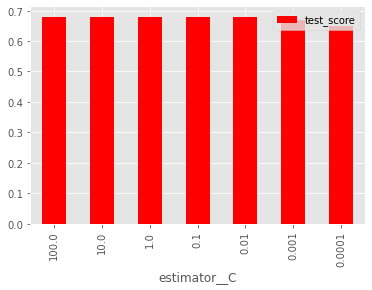

In [81]:
results_LR_one_other.plot(kind='bar',x='estimator__C',y='test_score',color='red')
plt.show()

The test score is very consistent among the different stimator c with penalization L2 (Ridge)

### Printing the grid best Estimator

In [82]:
ovr= regGridSearch.best_estimator_
ovr

OneVsRestClassifier(estimator=LogisticRegression(C=1))

### Using the grid best estimator to predict

In [83]:
ovr.fit(X_train, y_train)
y_hat = ovr.predict(X_test)

In [84]:
np.unique(y_hat, return_counts= True)

(array(['b', 'c'], dtype='<U1'), array([3700, 1605]))

# Performance of the model

The following is calculating the performance metrics to use in evaluating our model.   See below for a description of these metrics.

In [85]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = metrics.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = metrics.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= multilabel_confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 1728
Accuracy: 0.67
Precision= 0.6742695570216777
Recal= 0.6742695570216777
fscore= 0.6649970489954319
Confusion Matrix = [[[5287    0]
  [  18    0]]

 [[ 933 1052]
  [ 672 2648]]

 [[2662  676]
  [1038  929]]]


Micro option calculates TP,FP etc. globally, while macro does it specific to each class and averages them. Weighted is the weighted version of macro average that accounts for the different classes.

As you can see above we have a general accuracy of the model of 68 %. There are a total of 1728 missclasified outcome. 

The global precision of the model is is 68 %. Precision represents the number of correctly identified positive results divided by the number of all positive results.  

The global recall of the model is 67 %. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 

And accounting for the class imbalance, the the average of each class F score is 0.66. The f score is a harmonic mean of precision and recall. It is calculated from the precision and recall of the test. 


# Plot the confusion matrix

We ran a confusion matrix for our model using both normalized data and the original data.  Results are shown and described below.

Confusion matrix, without normalization
[[   0   14    4]
 [   0 2648  672]
 [   0 1038  929]]
Normalized confusion matrix
[[0.   0.78 0.22]
 [0.   0.8  0.2 ]
 [0.   0.53 0.47]]


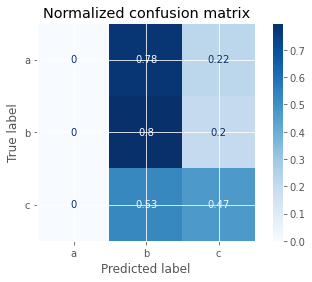

In [86]:
#set X and y with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
class_names = ["a", "b", "c"]

# Split the data into a training set and a test set
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# Run classifier, using a model that is too regularized (C too low) to see the impact on the results

classifier = ovr.fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


Due to the low number of sample from level one of blood pressure which is normal blood pressure, that particular category was not predicted, but we decided to continue with this model because the most important category to predict are the high and very high blood pressure. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

# ROC Curve one versus the others

Below you can see the ROC curve for each class. The normal blood pressure has a lower area under the curve than the  high or very high blood pressures. Also the classification of high blood pressure against the other classes has the same area under the curve as the very high classification of blood pressure. This ROC curve will allow us to choose the best alpha value in order to have the best sensitivity, true positive rate and the best false positive rate when we deploy the model.

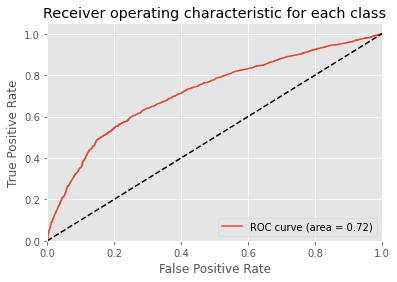

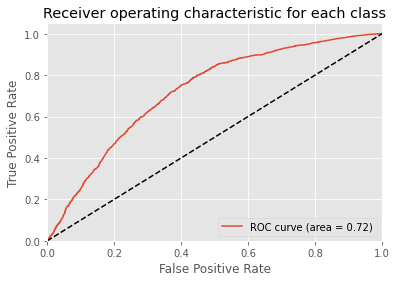

In [87]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
y = label_binarize(y, classes=["a", "b", "c"])
n_classes = 3

# shuffle and split training and test sets
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# classifier
y_score = ovr.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   

#Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()


# Extension of the ROC for multi class Logistic Regression one vs the others

Micro option calculates TP,FP etc. globally, while macro does it specific to each class and averages them. You can see in the below extention of the ROC for multi level clasification that the gloval ROC of the model is 83 % and the average ROC of the class is 70 %. The ROC per class is the same as the ROC showing above. 

In [88]:
from scipy import interp
from itertools import cycle

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw= 4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw= 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


/Users/tina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


# Classification Visualization

The graphs below are intended to show the split of the data for the "one versus other" categories of blood pressure. The color of the background represent what class a data point would be classified as if it lands in that region. The data, as represented by the dots, should fall into the correct category.

Automatically created module for IPython interactive environment
training score : 0.639 (multinomial)
training score : 0.639 (ovr)


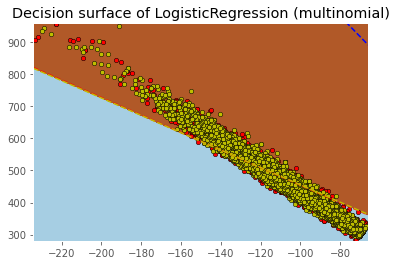

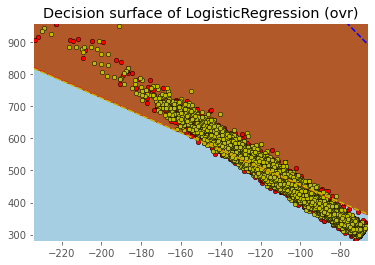

In [89]:
print(__doc__)
# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# create cross validation iterator
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


X = X_train
y = y_train
y = map(lambda x: 0 if x == "a" else (1 if x == "b" else 2), y)
y= np.array(list(y))

transformation = [[0.4, 3.2], [-1.4, 4.2],[0.4, 3.2], [-1.4, 4.2]]
X = np.dot(X, transformation)



for multi_class in ('multinomial', 'ovr'):
    ovr= OneVsRestClassifier(LogisticRegression(multi_class = multi_class))
    ovr.fit(X, y)
    clf = ovr
    
    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))
    # create a mesh to plot in
    h = .02 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')
    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20, alpha=.4)
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_
    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)
    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)
plt.show()

## Interpretation of variable weights

The category a of blood pressure, normal blood pressure is not being predicted by our model. The variables cardio, weight, and gender are negatively correlated with the prediction of normal blood pressure. In other words, if there are higher values for cardio, weight and gender (males are 1) you are more likely to fall ouside of the normal blood pressure category. Cardio has more importance than than weight,  and weight has more importance than gender. BMI is positively correlated with the prediction of normal blood pressure.   This could be due to the small number of observations in the normal blood pressure category, there were not enough data to train the model to predict this level of blood pressure.

In order to predict category b of bp, the variable "weight" is the only positively correlated variable for the prediction of bp2 (high blood pressure). Next in order of importance is the gender in order to predict high blood pressure. BMI is the strongest variable in order to not predict high blood pressure, as the coefficient's weight is negative. This is followed by cardio.  

For level c of bp (very high blood pressure), the cardio variable followed by BMI, weight and gender in that order, reflect the importance of the variables to predict bp (very high blood pressure).

In this case the comparison by level of blood pressure is each level against the other level of blood pressure.

Clearly, cardio event can be caused by high blood pressure, so the significant importance of cardio to predict very high blood pressure makes sense. The other variable( bmi, weight, gender) also make sense to predict high blood pressure, but in this data set they are less important than cardio.

bmi has weight of 0.2232653001173774
gender has weight of -0.18980452926260996
weight has weight of -0.38692732994708995
cardio has weight of -0.7004388289302154


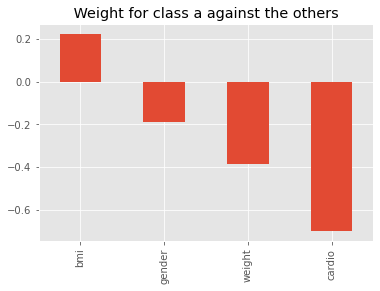

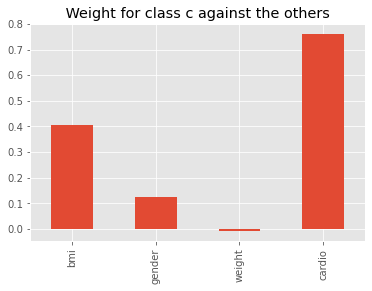

In [90]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# shuffle and split training and test sets
KFold(n_splits=10, random_state=None, shuffle=False)
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

# iterate over the coefficients
clf= ovr.fit(X_train_scaled, y_train)
weights = clf.coef_.T # take transpose to make a column vector
variable_names = ['bmi','gender','weight','cardio']
 
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
class_names = ["a", "b", "c"]
for i in [0,1,2]:
    weights = pd.Series(clf.coef_[i],index= variable_names)
    weights.plot(kind='bar')
    title= " Weight for class " + class_names[i] +" against the others "
    plt.title(title)
    plt.show()
    


# Creating a multi-class classifier with the multinomial logistic regression algorithm

We are performing the ovr and the multinomial algotithm in our multi class outcome of blood pressure categories of; normal, high and very high. Previously we did the one vs the others, now we will perform the multinomial algorithm in logistic regression.

In [91]:
#set X with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# create cross validation iterator
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


# Logistic regression model for the multiclass clasifier
model = LogisticRegression(solver = 'lbfgs', max_iter=10000, multi_class= 'multinomial')



# Grid search for the best parameter

We perform the grid search the same way as the grid search for one vs the others, please refer to the grid search explanation above.

In [28]:
#Create a Linear Regression object and perform a grid search to find the best parameters
model
parameters = {"C":np.logspace(-3,3,7), "penalty":["l2"]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=model
                   , param_grid=parameters
                   , cv= kf # KFolds = 10
                   , scoring='f1_micro')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)# use the model to make predictions with the test data

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

# Print the test score per parameter and visualize it

The test score is very consistent among the different values of the C parameter.

In [29]:
regGridSearch.cv_results_['mean_test_score']
results_LR_one_other = pd.DataFrame(regGridSearch.cv_results_['params'])
results_LR_one_other['test_score'] = regGridSearch.cv_results_['mean_test_score']
results_LR_one_other


C penalty  test_score
0     0.001      l2    0.675232
1     0.010      l2    0.679756
2     0.100      l2    0.680112
3     1.000      l2    0.680196
4    10.000      l2    0.680175
5   100.000      l2    0.680175
6  1000.000      l2    0.680196

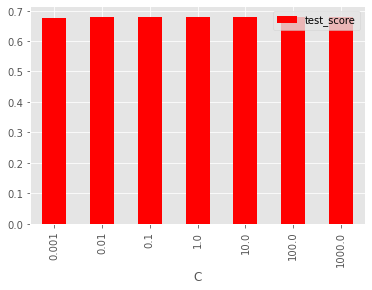

In [30]:
results_LR_one_other.plot(kind='bar',x='C',y='test_score',color='red')
plt.show()

# Print the best parameter

In [31]:
#Perform hyperparameter search to find the best combination of parameters for our data
model= regGridSearch.best_estimator_
model

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Predict with the best parameter

In [32]:
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

# Get the performance of the model

As you can see below we have a general accuracy of the model of 68%. There is a total 1492 misclasified outcome. 

The global precision of the model is is 67 %. Precision represents the number of correctly identified positive results divided by the number of all positive results.  

The global recall of the model is 67 %. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 


And acounting for the class inbalance, the the average of each class F score is 0.66. The F score is a harmonic mean of precision and recall. It is calculated from the precision and recall of the test. 

This metric of performance in the multinomial logistic regresion model is similar to the one versus the other algorithm in the logistic regresion model

The algorithm for multinomial clasification gives us the same result as the algorithm for one versus the other, so we choose to keep the one versus the other multiclass algorithm.

In [33]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = metrics.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = metrics.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= multilabel_confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 1728
Accuracy: 0.67
Precision= 0.6742695570216777
Recal= 0.6742695570216777
fscore= 0.665052811502759
Confusion Matrix = [[[5287    0]
  [  18    0]]

 [[ 934 1051]
  [ 673 2647]]

 [[2661  677]
  [1037  930]]]


# Pro and Cons of Logistic Regression

Advantages of Logistic Regression

1. Logistic Regression performs well when the dataset is linearly separable.

2. Logistic regression is less prone to over-fitting but it can overfit in high dimensional datasets. You should consider Regularization (L1 and L2) techniques to avoid over-fitting in these scenarios.

3. Logistic Regression not only gives a measure of how relevant a predictor (coefficient size) is, but also its direction of association (positive or negative).

4. Logistic regression is easier to implement, interpret and very efficient to train. 

Disadvantages of Logistic Regression

1. Main limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables. In the real world, the data is rarely linearly separable. Most of the time data would be a jumbled mess.

2. If the number of observations are lesser than the number of features, Logistic Regression should not be used, otherwise it may lead to overfit.

3. Logistic Regression can only be used to predict discrete functions. Therefore, the dependent variable of Logistic Regression is restricted to the discrete number set. This restriction itself is problematic, as it is prohibitive to the prediction of continuous data.

# KNN Model

KNN is simple to use and can return very accurate and meaningful results. It also tends to be computationally expensive, so it may not be your best choice for more massive datasets. For a larger dataset with binary classification, a simple logistic regression may be a better choice. In other cases, a random forest classifier could be a better choice. It is always a good idea to try out as many models as possible to get the most accurate machine learning predictions.

We will set up the dataframe df2 for the KNN model.

In [6]:
#Let examine the height, weight and blood pressure
df2 = df[['age','bmi','cholesterol','gluc','smoke', 'alco','active','cardio','bp2']]
df2.head()

age        bmi  cholesterol  gluc  smoke  alco  active  cardio bp2
1  20228  34.927679            3     1      0     0       1       1   c
2  18857  23.507805            3     1      0     0       0       1   b
3  17623  28.710479            1     1      0     0       1       1   c
5  21914  29.384676            2     2      0     0       0       0   b
6  22113  37.729725            3     1      0     0       1       0   b

### Correlation of all the variable with blood pressure

Decided to go with 'age', 'bmi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' and 'bp2'. This is to include all the paramters and only drop the co-linear parameters. Variable weight calculations do not make sense for KNN so our team looked at correlation. 

In [7]:
def score_to_numeric(x):
    if x=='c':
        return 3
    if x=='b':
        return 2
    if x=="a":
        return 1
df2["bp2"] = df2["bp2"].apply(score_to_numeric)
   
correlations = df2.corr()['bp2'].drop('bp2')
print(correlations)

age            0.096769
bmi            0.210418
cholesterol    0.166203
gluc           0.063470
smoke          0.024959
alco           0.038444
active         0.014002
cardio         0.350548
Name: bp2, dtype: float64


The variables: BMI, Cardio and Cholestrol show higest correleation to the blood pressure categories.

# Pie Chart of the intended outcome

This is to show graphicaly the distribution of the intended outcome. As the pie chart shows, we have very less sample in the normal blood pressure range, however, there is a good among of data in level 2 and level 3. As discussed earlier in the previous model, this distribution of the data may inpact the confusion matrix.

<AxesSubplot:ylabel='bp2'>

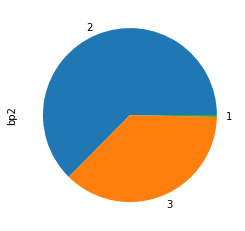

In [12]:
# glucose Pie Chart
df2["bp2"].value_counts().plot(kind='pie')

##### Normalize/ Standardize the variables for KNN

The given data frame is not standardized.  If the data is not normalized then the interpretation of the outcome by the given variables will be misleading.  Standardizing the features around the center and 0 with a standard deviation of 1 is important when model compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

In [13]:
scaler = StandardScaler()
scaler.fit(df2.drop(['bp2'],axis=1))
scaled_features = scaler.transform(df2.drop(['bp2'],axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df2.columns[:-1])
df_feat.head()

age       bmi  cholesterol      gluc     smoke     alco    active  \
0  0.228071  1.326219     2.265255 -0.410419 -0.314747 -0.24278  0.500041   
1 -0.344422 -0.898524     2.265255 -0.410419 -0.314747 -0.24278 -1.999835   
2 -0.859708  0.115026    -0.561279 -0.410419 -0.314747 -0.24278  0.500041   
3  0.932101  0.246368     0.851988  1.276832 -0.314747 -0.24278 -1.999835   
4  1.015198  1.872094     2.265255 -0.410419 -0.314747 -0.24278  0.500041   

     cardio  
0  0.888532  
1  0.888532  
2  0.888532  
3 -1.125451  
4 -1.125451

# Split the data for the KNN model

We are using for the KNN model a 10-k fold validation, in order to use all the data for the training of the model in this multi class outcome in alignment with the previous model.

In [9]:
# create cross validation iterator
#kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
kf = ShuffleSplit()
X =df2[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values
y = df2[['bp2']].values
for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

## Choosing a K Value

We will choose an optimal K value to minimize the error rate in the model.

We create a loop that trains various KNN models with different K values, then keep track of the error_rate for each of these models with a list. The error appears to flatten out at a low at around k=200. We also tried up to k=500 and the error rate continues to stay flat. However in the grid search that we will do later, we optimize the K parameter along with the other parameters and may get a different value of K. Also the grid search will optimize for F1 score whereas this graph is showing the error rate.

In [10]:
error_rate = []

# Will take some time
for i in range(1,200):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Now create the following plot using the information from your for loop.¶

In [11]:
    
plt.figure(figsize=(20,12))
plt.plot(range(1,200),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Error Rate')

#### We are running the test and training dataset separately to show that the accuracy get stabilized between 20 and 30 K neighbor

K Value is balanced among Bias, Variance, Accuracy, and Complexity.  In the extreme case, when K=1, the training data will be correctly predicted (or close to perfect). The bias will be zero(0) when K= 1. However, when it comes to new data (in the test set), it has a higher chance of being an error (low accuracy), causing high variance. When we increase K, the training error will increase (increase bias), but the test error may decrease at the same time (decrease variance). When K becomes larger, since it has to consider more neighbors, its model is more complicated. The graph below split the data into training and validation set and decide what K should be like. We need to find the right balance among bias, variance, accuracy, and complexity.


In [14]:
#import KNeighborsClassifier
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,100)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    #Fit the model 
    knn.fit(X_train, y_train) 
    #Compute accuracy on the training set 
    train_accuracy[i] = knn.score(X_train, y_train) 
    #Compute accuracy on the test set 
    test_accuracy[i] = knn.score(X_test, y_test) 

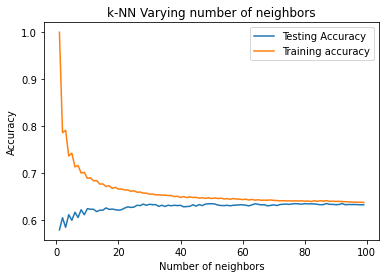

In [14]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

### KNN is a GridSearchCV
The most common hyperparameters that impact the KNN model in terms of overfitting and underfitting are discussed below.

**N_neighbor**, this defines how many neighbors should be taken into account to predict the new values.

**Weight**, this parameter can be set to either 'uniform' where each neighbor within the boundary carries the same weight, or 'distance' where closer points will be more heavily weighted toward the decision. Note that when weights = 'distance,' the class with the highest number in the boundary may not "win the vote".

**Metric**, refers to how the distance of neighboring points is chosen from the unknown point. As modeling is generally done in more than three dimensions, this can be difficult to visualize.

In [17]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
grid_param = {
    #'k_range' = list(range(1,100))
    'n_neighbors': [59,69,71,85,81,75,91,73,91,93],
    'weights': ['uniform','distance'],
    'metric' : ['euclidean','manhattan', 'Minkowski']
}

gs = GridSearchCV(
KNeighborsClassifier(),
grid_param,
verbose = 1, # verbose: the higher, the more messages
cv = 5,
n_jobs = -1,
return_train_score=True,
scoring = 'f1_micro'
)
gs_results = gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished


# Get the best parameter

In [18]:
gs_results.best_score_

0.6361522310661075

# Get the score for the different model

It show a very stable mean test score for the different model

In [19]:
gs_results.cv_results_['mean_test_score']

array([0.63012053, 0.63051851, 0.62936662, 0.63051847, 0.63018341,
       0.63049752, 0.62815197, 0.63114678, 0.62878028, 0.63070697,
       0.62942944, 0.63079078, 0.62806817, 0.63123058, 0.62957605,
       0.6307698 , 0.62806817, 0.63123058, 0.62869644, 0.6307908 ,
       0.63523077, 0.63602659, 0.63336679, 0.63523074, 0.63345054,
       0.63579623, 0.63164938, 0.6359428 , 0.63215202, 0.63583809,
       0.63347144, 0.63615223, 0.63154469, 0.63462338, 0.63351335,
       0.63613128, 0.63154469, 0.63462338, 0.63158655, 0.63460246,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [20]:
results_KNN = pd.DataFrame(gs_results.cv_results_['params'])

results_KNN['test_score'] = gs_results.cv_results_['mean_test_score']


# Get the best parameter

These are the parameters that the grid search found to be the best.

In [21]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 75, 'weights': 'distance'}

# Get the prediction with the best parameter

In [15]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=75, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

### Retrain with new K Value
Retrain your model with the best K value (up to you to decide what you want) and re-do the classification report and the confusion matrix.

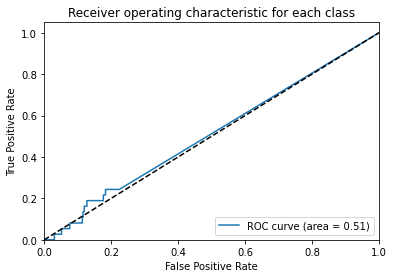

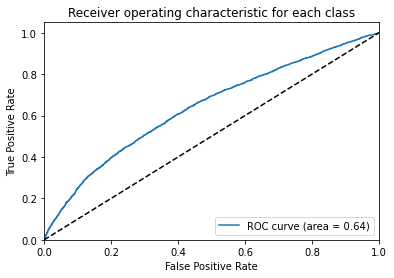

In [16]:
X =df2[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values
y = df2[['bp2']].values
y=y.reshape(-1,1)
# Binarize the output
y = label_binarize(y, classes=[1,2,3])
n_classes = 3
        
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                   random_state=0)

# classifier
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=75, weights='distance')
clf = OneVsRestClassifier(knn)
y_score = clf.fit(X_train, y_train).predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()


##### https://www.edureka.co/blog/classification-in-machine-learning/
    
##### ROC Curve

Receiver operating characteristics or ROC curve is used for visual comparison of classification models, which shows the relationship between the true positive rate and the false positive rate. The area under the ROC curve is the measure of the accuracy of the model. The first level of blood pressure is close to 50 and the other 2 level of blood pressure have the 64% area under the curve

Below is the graph with all the RoC combined on one plot. 

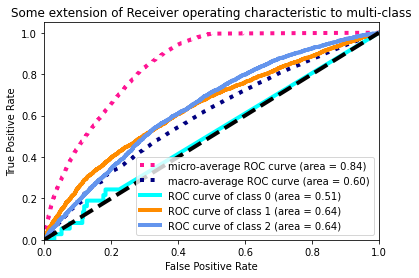

In [17]:
from scipy import interp
from itertools import cycle

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw= 4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw= 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### Caluclate Accuracy and Classification

In [18]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=75, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('Accuracy')
print('Accuracy:',accuracy_score(y_test, y_pred))
print('Classification Report')
print(classification_report(y_test,y_pred))

Accuracy
Accuracy: 0.6266138912449345
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.64      0.91      0.75      6606
           2       0.53      0.15      0.24      3968

   micro avg       0.63      0.63      0.63     10611
   macro avg       0.39      0.36      0.33     10611
weighted avg       0.60      0.63      0.56     10611
 samples avg       0.63      0.63      0.63     10611



In [19]:
confusion_matrix(
    y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[   1,   35,    1],
       [  24, 6043,  539],
       [  31, 3331,  606]], dtype=int64)

Due to the low number of sample from level one of blood pressure which is normal blood pressure, that particular category was not predicted, but we decided to continue with this model because the most important category to predict are the high and very high blood pressure. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

[[   1   35    1]
 [  24 6043  539]
 [  31 3331  606]]


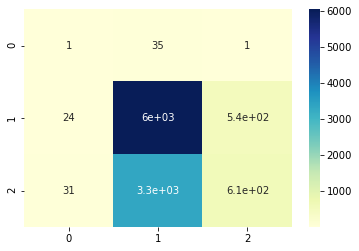

In [20]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(CM)

# Visualize it as a heatmap
import seaborn
#heat_map = sb.heatmap(data, cmap="YlGnBu")

seaborn.heatmap(CM,annot=True, cmap="YlGnBu" )
plt.show()

https://www.edureka.co/blog/classification-in-machine-learning/

##### Accuracy 

Accuracy is a ratio of correctly predicted observation to the total observations
True Positive: The number of correct predictions that the occurrence is positive.
True Negative: Number of correct predictions that the occurrence is negative.

Accuracy is coming to 63%. 
##### F1- Score

It is the weighted average of precision and recall. f1 values are 0, 0.75 and 0.22. 

##### Precision And Recall
Precision is the fraction of relevant instances among the retrieved instances, while recall is the fraction of relevant instances that have been retrieved over the total number of instances. They are basically used as the measure of relevance.
Precision value is 0 as we discussed above number of samples are very low in this bucket. bp level 2 and 3 are range of 50% to 60%. Recall is zero(0) for Normal BP howere 92% for level 2 and 14% for level 3. 

In the confusion matrix the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

### Basic binary classification with KNN

Blue areas are the positive class, and red are the negative class. This plot shows how KNN uses the classes of the training points to make regions where new points would be classified positively or negatively based on their nearest neighbors.

Note: this graph only shows up if the jupyter notebook is run as "Trusted"

In [23]:
 # https://plotly.com/python/knn-classification/

import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot

mesh_size = .02
margin = 0.25

# Load and split data
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y.astype(str), test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(metric='manhattan', n_neighbors=75, weights='distance')
clf.fit(X, y)
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)


# Plot the figure
fig = go.Figure(data=[
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        colorscale='RdBu'
    )
])


fig.show()

### Pro and Con of KNN

##### **Pro**
The training phase of K-nearest neighbor classification is much faster compared to other classification algorithms. There is no need to train a model for generalization, That is why KNN is known as the simple and instance-based learning algorithm. KNN can be useful in case of nonlinear data. It can be used with the regression problem. Output value for the object is computed by the average of k closest neighbors value.

##### **Cons**
The testing phase of K-nearest neighbor classification is slower and costlier in terms of time and memory. It requires large memory for storing the entire training dataset for prediction. KNN requires scaling of data because KNN uses the Euclidean distance between two data points to find nearest neighbors. Euclidean distance is sensitive to magnitudes. The features with high magnitudes will weight more than features with low magnitudes. KNN also not suitable for large dimensional data.

## -----------------------------------------------------------------------------------------------------------------------

# Random Forest for Blood Pressure Classification

## Split the data according to 10 K fold stratified validation

In [31]:
X =df2[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values
y = df2[['bp2']].values
y = map(lambda x: 0 if x == 1 else (1 if x == 2 else 3), y)
y= np.array(list(y))

# create cross validation iterator
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]



## Create a grid to pick up the parameter for the Random Forest model

We created a grid search to find the best parameter, and with checked with gini and entropy which are the two criterio to evaluate the decision tree.

<b>Random_state</b>:
In RandomForestClassifier , a random number can be used to find a set of random features to build a predictor. Algorithms that use subsampling can use random numbers to get different subsamples. Similar to seed random_state plays a role in multiple random numbers of generations. This parameter makes it easy for others to replicate your results if given the same training data and parameters.

<b>n_estimator</b>:
The number of trees in the forest. The Random Forest algorithm is the grouping of the trees. More trees should be able to produce a more generalized result (The higher the number, the better). However, by choosing more trees, the Random Forest model's time and complexity also increase. The performance of the model sharply increases and then stagnates at a certain level. Therefore, choosing a large number of estimators in a random forest model is not the best idea. Choosing a lower number will not degrade the model without consuming a lot of processing power.

<b>max_feature</b>:
The maximum features provided to each tree in a random forest. In random forest f1, value improvements are drastic initially, then start stagnating or even degrading, this is an indication of overfitting. By increasing the number of features, processing speed will decrease. max_features is one of the more complicated parameters as it is dependent on the type as well.

<b>integer</b>: It is directly a number float: It is a percentage auto or sqrt: It is set to the square root of the number of features (sqrt(n_feature)) log2: is defined as Log2(n_features)

<b>max_depth</b>:
max-depth selects the depth of your tree. It is critical to set the depth. Else model runs into the risk of overfitting.

<b>criterion</b>:
criterion measures the quality of each split. There are two option, "gini" or "entropy" gini: Uses the Gini impurity entropy: makes split based on the information gain.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

dt_clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
dt_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

# Best parameter

In [33]:
dt_clf.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'log2',
 'n_estimators': 500}

## Performance of the Random Forest model

This model has a acccuracy of 68 %. It has a precision of 74 % for the level 2 blood pressure and a precision of 58% for level 3 blood pressure, it does not predict level 1 blood pressure, this is due to very small dataset in level 1 blood pressure. There is 177 row in level 1 compare to approximately 30000 in level 2 and 19000 in level 3. Recall is 0 for 1, 75% for 2 and 57% for level 3. The f1-score is 0 for level 1, 75 for level 2 and 57 for level 3. The 0% in for level 1 in recall and f1-score is for the same reason that the model did not computed precision, there is not prediction at all of level 1 due to inbalaced data. Micro option calculates TP,FP etc. globally, while macro does it specific to each class and averages them.Weighted is the weighted version of macro average that accounts for class imbalance. The macro precision is 0.44, the macro recall 0.44 and the weighted f 1 score is 0.68. 

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predictions= dt_clf.predict(X_test)
precision = metrics.precision_score(y_test, predictions, average='micro')
print("Precision=", precision)
recal = metrics.recall_score(y_test, predictions, average='micro')
print(recal)
fscore = metrics.f1_score(y_test, predictions, average='weighted')
print("fscore=",fscore )
print(classification_report(y_test,predictions))
accuracy_score(y_test,predictions)

Precision= 0.6829406220546654
0.6829406220546654
fscore= 0.6813901700930122
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.74      0.75      0.75      3320
           3       0.58      0.57      0.57      1967

    accuracy                           0.68      5305
   macro avg       0.44      0.44      0.44      5305
weighted avg       0.68      0.68      0.68      5305



/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6829406220546654

## Confusion matrix

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [111]:
# Visualise classical Confusion M0atrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, predictions)
print(CM)

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(CM)
plt.show()

[[   0   13    5]
 [   0 2499  821]
 [   0  843 1124]]


## ROC curve for Random Forest

Below you can see the ROC curve for each class. The clasification of normal blood pressure against the other class high and very high blood pressure,  has a lower area under the curve than the possibility of classifing high or very high blodd pressure against the other class. Also the clasification of high blood pressure agains the other class has the same area under the curve than the very high clasification of blood pressure. This ROC curve will allowed to choose the best alpha value in order to have the best sensitivity, true positive value and the best false positive rate when we deploy the model.

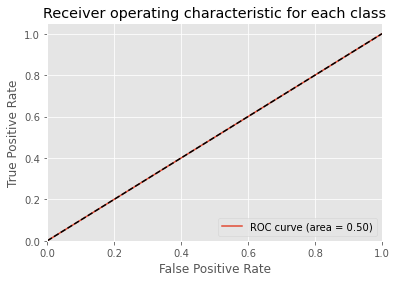

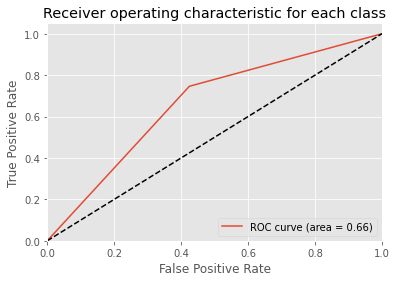

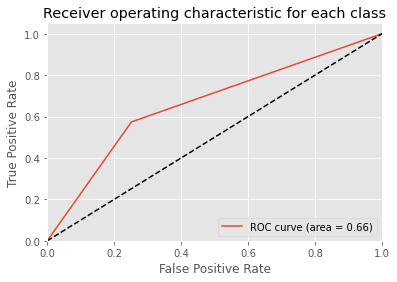

In [115]:
X =df2[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values 
y = df2['bp2'].values
y = label_binarize(y, classes=[1,2,3])
n_classes = 3

# shuffle and split training and test sets
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# classifier we use one versus the other to plot the fiferents class
classifier = dt_clf
y_score = classifier.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()


## Important features

We selected the features 'age', 'bmi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' because we considered all of them to be important to predict high blood pressure.

The feature importances can be calculated using the mean decrease in the gini index. Essentially, every time a feature is tested for splitting, the decrease in the gini (or entropy) is saved. The importance of the feature can then be approximated by taking the mean decrease in the gini for all the nodes where the feature is tested (usually the feature is tested at every node).

The cardio feature has the highest mean entropy decrease. It is followed by BMI, cholesterol, and age. BMI is more important than the cholesterol, and the cholesterol is more important than the age. Finally,glucose, alcohol, active and smoke have the lowest mean decreased in entropy, therefore they are lest important variable in the present model.

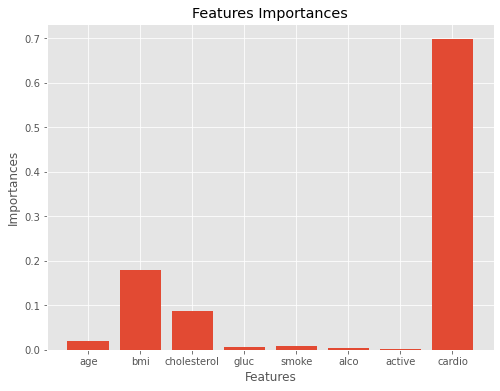

In [117]:
variable_names = ['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                min_samples_split=1000, min_samples_leaf=1, 
                                max_leaf_nodes=None)

dt_clf.fit(X_train, y_train)
dt_clf.predict(X_test)

# get the importances
imp = dt_clf.feature_importances_

#plot the importances as bar chart
plt.figure(figsize=(8, 6))
plt.bar(variable_names,imp)
plt.title("Features Importances")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

# Tree visualization

Below is a visualization of a single decision tree from our model

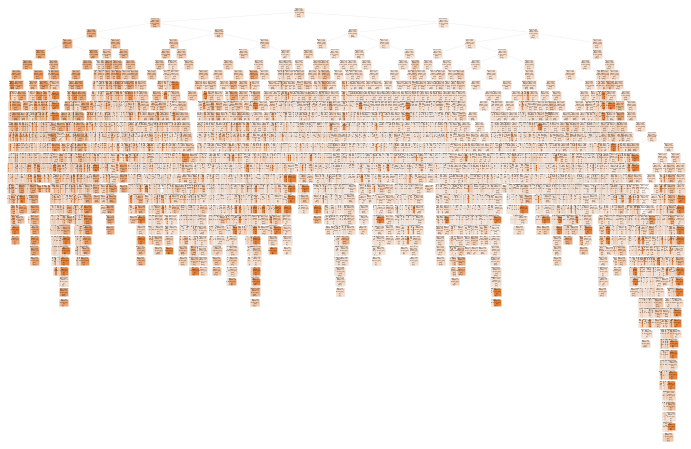

In [360]:
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
y = label_binarize(y, classes=["a", "b", "c"])
names= ["a", "b", "c"]
variable_names = ['bmi','gender','weight','cardio']

# shuffle and split training and test sets
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
 

# classifier we use one versus the other to plot the fiferents class
rf = RandomForestRegressor(n_estimators= 3)
rf.fit(X, y)

_ = tree.plot_tree(rf.estimators_[0], feature_names= variable_names, filled=True)


[Text(776.9198863636365, 498.3, 'X[7] <= 0.5\nentropy = 0.646\nsamples = 47748\nvalue = [[47584, 164]\n[17889, 29859]\n[30023, 17725]]'),
 Text(432.1329545454546, 407.70000000000005, 'X[1] <= 27.869\nentropy = 0.475\nsamples = 21056\nvalue = [[20930, 126]\n[3913, 17143]\n[17269, 3787]]'),
 Text(239.05227272727274, 317.1, 'X[2] <= 1.5\nentropy = 0.387\nsamples = 13727\nvalue = [[13644, 83]\n[1805, 11922]\n[12005, 1722]]'),
 Text(147.10909090909092, 226.5, 'X[1] <= 25.712\nentropy = 0.35\nsamples = 11933\nvalue = [[11868, 65]\n[1351, 10582]\n[10647, 1286]]'),
 Text(73.55454545454546, 135.89999999999998, 'X[0] <= 21411.5\nentropy = 0.316\nsamples = 8669\nvalue = [[8630, 39]\n[844, 7825]\n[7864, 805]]'),
 Text(36.77727272727273, 45.299999999999955, 'entropy = 0.293\nsamples = 7319\nvalue = [[7284, 35]\n[637, 6682]\n[6717, 602]]'),
 Text(110.33181818181819, 45.299999999999955, 'entropy = 0.419\nsamples = 1350\nvalue = [[1346, 4]\n[207, 1143]\n[1147, 203]]'),
 Text(220.66363636363639, 135.89

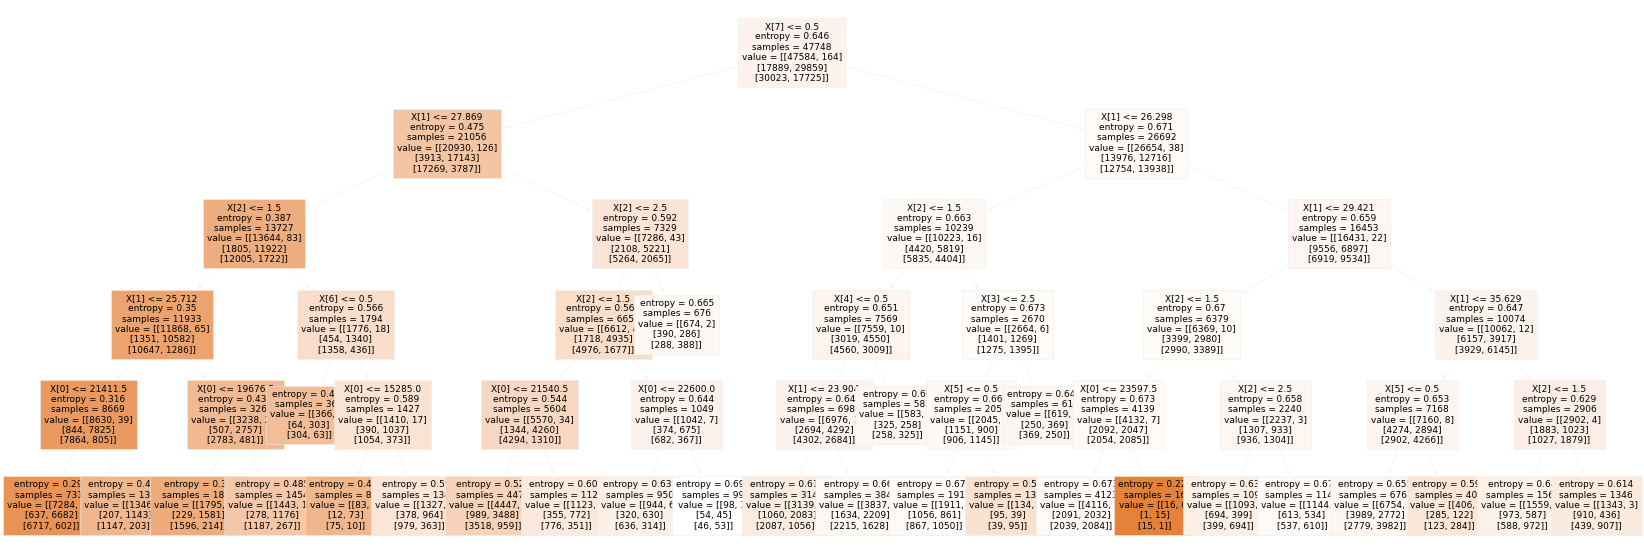

In [119]:
fig, ax = plt.subplots(figsize=(29, 10))  # whatever size you want
tree.plot_tree(dt_clf, ax=ax, filled=True, fontsize=9)

In [359]:
rf.estimators_[0].tree_.max_depth

42

https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_classification_algorithms_random_forest.htm#:~:text=Pros%20and%20Cons%20of%20Random%20Forest%20Pros.%20The,forest%20has%20less%20variance%20then%20single%20decision%20tree.

### Pros and Cons of Random Forest

#### Pros
The following are the advantages of Random Forest algorithm −

It overcomes the problem of overfitting by averaging or combining the results of different decision trees.

Random forests work well for a large range of data items than a single decision tree does.
 
Random forest has less variance then single decision tree.

Random forests are very flexible and possess very high accuracy.

Scaling of data does not require in random forest algorithm. It maintains good accuracy even after providing data without scaling.

Random Forest algorithms maintains good accuracy even a large proportion of the data is missing.

#### Cons
The following are the disadvantages of Random Forest algorithm −

Complexity is the main disadvantage of Random forest algorithms.

Construction of Random forests are much harder and time-consuming than decision trees.

More computational resources are required to implement Random Forest algorithm.

It is less intuitive in case when we have a large collection of decision trees.

The prediction process using random forests is very time-consuming in comparison with other algorithms.

# Comparison of the different model for the outcome of blood pressure

In [42]:
clf1 = LogisticRegression(C=1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)  

clf2 = KNeighborsClassifier(metric='manhattan', n_neighbors=59, weights='uniform')

clf3 = RandomForestClassifier(criterion = 'gini', max_depth  = 7, max_features = 'log2', n_estimators =  500)


from sklearn.model_selection import cross_val_score
# is clf1 better or worse than clf2 or clf3?
X =df2[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values 
y = df2['bp2'].values
cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(clf1, X, y=y, cv=cv)
acc2 = cross_val_score(clf2, X, y=y, cv=cv)
acc3 = cross_val_score(clf3, X, y=y, cv=cv)

In [48]:
# %load -r 19-28 statcompare.py
t = 2.26 / np.sqrt(10)

# Comparison between CLF1 and CLF 2
e = (1-acc1)-(1-acc2)
stdtot = np.std(e)
dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(acc1), np.mean(acc2))

# Comparison between CLF1 and CLF 3
e1 = (1-acc1)-(1-acc3)
stdtot1 = np.std(e1)
dbar1 = np.mean(e1)
print ('Range of:', dbar1 - t*stdtot1, dbar1 + t*stdtot1 )
print (np.mean(acc1), np.mean(acc3))

# Comparison between CLF2 and CLF 3
e2 = (1-acc2)-(1-acc3)
stdtot2 = np.std(e2)
dbar2 = np.mean(e2)
print ('Range of:', dbar2 - t*stdtot2, dbar2 + t*stdtot2 )
print (np.mean(acc2), np.mean(acc3))

Range of: -0.03410287551216809 -0.019051020296215568
0.6636755573065968 0.637098609402405
Range of: 0.01694978839550218 0.035563707076520505
0.6636755573065968 0.6899323050426082
Range of: 0.04872905594887396 0.05693833533153238
0.637098609402405 0.6899323050426082


According to this performance the Random Forest model performed the best in comparison to the logistic regression and the KNN model. It has an accuracy of 68 % in comparison to 66 % by the logistic regression model and 63 with the KNN model. The 95% range of error is between 0.01694978839550218 and 0.035563707076520505 in comparison to the logistic regression model, and the 95% range of error was 0.04872905594887396 0.05693833533153238 in comparison to the KNN model, which is statistically significant because the confidence interval does not include 0. For completness, the comparison between the logistic regression model and the KNN model was statistically significant for the 95% in the range of -0.03410287551216809 -0.019051020296215568, the logistic regression model performed better. 

The model that we will pick is the Random Forest because it performed better with the same dataset from the error perspective, better accuaracy, and most importantly it has a better weight f 1 score than the other 2 models, its weight f1 score is 68 % in comparison to the weight score of 66 from the other 2 model. That is the advantage from the random forest over the othr 2 model, KNN and logistic regression. 

The disadvantage of the random forest model is that it can be a little more difficult to explain to the targeted audience. But This accuaracy score is a metric that the audience could interprect easily.


## Model Selection Conclusion

The chosen model is Random forest with the selected variables = ('age','bmi','cholesterol','gluc','smoke','alco','active','cardio'). We will use the model to predict the patients who have high or very high blood pressure with an accuracy of 68%. We also have a f1 score of .68 so we have a balance in not overcalling blood pressure high or very high. We can predict , so the patient can be place under treatment for high blood pressure and avoid a heart attack (cardio). We would keep this model stable, but in the future with a more balance data this model can be retrained in order to pick up the normal level of blood pressure and the high and very high blood pressure. 

# Deployment


The way that this model will be used is that each patient who come to the clinic, the variables mentioned above would be measure and the patient will be told the possibility of having high or very high blood pressure. This model would be a scrutinizing factor, because there is a chance that a blood pressure result of "normal" is a false negative, which is common in the clinical practice. If the measured blood pressure is normal at the time of the visit but is flagged by our model, a patient would need to be retested, for example come back to the clinic 2 more times to check his blood pressure again. This model would help ensure that doctors do not miss patients with high blood pressure who had false negative measures at the time of visit. The cost of 2 more visits is much less than the medical damage that could result from the high or very high blood pressure that was not pick up by the clinical visit.

We would also let the intended audience know that this model has data imbalance, and because the level 1 of blood pressure, which is normal blood pressure, has much fewer sample in comparison to the high and very high blood pressure. The intent of this model is not to predict normal blood pressure.

The team feels strongly that the model is doing its job well, of predicting high and very high blood pressure. This model is able to predict high and very high blood pressure with an accuracy of 68%, and has a good balance between false positives and false negatives.

## --------------------------------------------------------------------------------------------------

# Task 2: Cardio Classification

In this section, we create 3 models for predicting the presence of cardiac disease: Logistic Regression, Random Forest, and KNN.

## Evaluation Metrics

For the cardiac disease prediction model, we chose the F1 score as the evaluation metric to show a good balance between precision and recall, which is important because cardiac disease is a severe issue and we would prefer to sacrifice accuracy in favor of recall in order to reduce false negatives, since a false negative may result in death due to a person not getting the healthcare they need.

# Data Preparation

This is a refresh of the data cleaning done at the beginning of this file, just consdensed and repeated here in case the dataframe was altered in any of the process in the previous sections.

In [13]:
#load in data
df = pd.read_csv("/Users/tina/Documents/School/ML1/SMUMSDS-ML1/cardio_train.csv", sep=";")

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2



## Cross Validation Method

We chose to do a cross validation using 3 repetitions of 80% train and 20% test. We thought an 80/20 split was good to use most of our data for training while still having enough for testing. We chose 3 repetitions because it is enough repetitions to give us a sense of the stability of the model while not being so many as to take too long to run.

We use this cross validation method on all of our model options.

In [14]:
#our target variable is cardio
y = df['cardio'].values

#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Logistic Regression Model for Cardiac Events

## Data Preparation

### Variable Selection: BMI, ap_hi, ap_lo, cholesterol, age

The logistic regression model includes the following variables: bmi, ap_hi (systolic blood pressure), ap_lo (diastolic blood pressure), cholesterol, age <br>     We ran multiple logistic regression models in our MiniLab and compared them to our initial exploratory data analysis done in the first lab.   From this analysis, we determined that these variables had the highest correlation to the cardio response variable.  

After running several exploratory models, we determined that we needed to scale the data.  Without scaling the data, cholesterol becomes the variable with the most weight.  However, this does not give us the best model and it does not match our exploratory data analysis which shows that high blood pressure has the highest correleation to cardiac events.  Scaling the data brings the varaibles into a consistent range for comparason.  


In [35]:
#set X with our desired variables
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 

### Scaling

In this section, we create a model with the above variables using scaled data.  Without scaling the data, the cholesterol variable is on a scale from 1-3, the BMI is typically in the 20-30 range and the blood pressure variables are in the 80-200 range.  Scaling them allows the model to get the true weights of the variables.

## Hyperparameter Tuning

Here, we tune the hyperparameters for the model. We get the highest AUC of 0.78 using {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}.   By trying various option combination, this allows us to choose our best logistic regression model.

The hyperparameters are:

**C:** This controls the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decreased which allows the model to increase its complexity, and therefore, overfit the data.

**Penalty:** This project uses two penalties. L1 and L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables. Lasso (L1) performs feature selection by shrinking the less important feature’s coefficient to zero. Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso. Both penalty values restrict solver choices. It is critical to choose the right combination of Penalty.

**Solver:** Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. other possible values (to list few) are, liblinear, sag and saga. liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes. lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty. saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty. sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.

Ref: https://sigopt.com/blog/common-problems-in-hyperparameter-optimization
https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d

In [34]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))


Best: 0.771513 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


In [35]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.771513 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.771510 (0.002193) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.771513 (0.002193) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.771501 (0.002194) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.771502 (0.002195) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.771499 (0.002196) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.771501 (0.002194) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.771500 (0.002196) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.771500 (0.002195) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.771499 (0.002195)

In [15]:
fav_lr_clf =  Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))])

###  ROC Curve

This is the ROC curve for our Logistic Regression with Scaled Data. The ROC curve shows that the threshold with the best precision and recall should lie between alpha=.2 and alpha=.6.

Logistic: ROC AUC=0.771


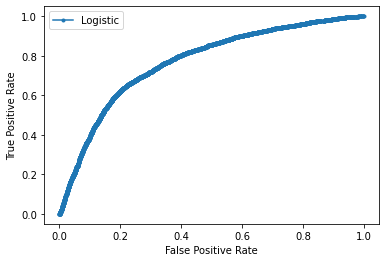

In [36]:

fav_lr_clf.fit(X_train, y_train)

# predict probabilities
fav_lr_probs = fav_lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
fav_lr_probs = fav_lr_probs[:, 1]
# calculate scores
fav_lr_auc = roc_auc_score(y_test, fav_lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (fav_lr_auc))
# calculate roc curves
fav_lr_fpr, fav_lr_tpr, _ = roc_curve(y_test, fav_lr_probs)
# plot the roc curve for the model
pyplot.plot(fav_lr_fpr, fav_lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Tuning Alpha

The following shows accuracy of the model for alpha values between .2 and .6.  The optimal alpha value for our model is .40.  This alpha value gives us an F1 score of .760. Therefore, we will classify a point as a cardiac event if it has a predicted probability greater than .40.

In [38]:
y_prob =fav_lr_clf.predict_proba(X_train)[:,1]
alphas = np.arange(.2, .6, .02)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, y_prob))
    f1 = mt.f1_score(y_train, y_hat)
    print('alpha %f : f1=%.3f' % (alpha, f1))

alpha 0.200000 : f1=0.718
alpha 0.220000 : f1=0.722
alpha 0.240000 : f1=0.727
alpha 0.260000 : f1=0.733
alpha 0.280000 : f1=0.738
alpha 0.300000 : f1=0.743
alpha 0.320000 : f1=0.750
alpha 0.340000 : f1=0.755
alpha 0.360000 : f1=0.759
alpha 0.380000 : f1=0.761
alpha 0.400000 : f1=0.763
alpha 0.420000 : f1=0.760
alpha 0.440000 : f1=0.756
alpha 0.460000 : f1=0.750
alpha 0.480000 : f1=0.743
alpha 0.500000 : f1=0.736
alpha 0.520000 : f1=0.729
alpha 0.540000 : f1=0.723
alpha 0.560000 : f1=0.714
alpha 0.580000 : f1=0.704


#### Metrics

Below we show the accuracy metrics for the model. It has an AUC of .77, F1 score of .73, and accuracy of .71.

In [38]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    fav_lr_clf.fit(X_train,y_train)
    
    y_prob=fav_lr_clf.predict_proba(X_test)[:,1]
    alpha = .4
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, y_prob))

    print("====Iteration",iter_num," ====")
    #Show AUC
    auc = mt.roc_auc_score(y_test,y_prob)
    print("auc", auc )
    
    #Show confusion matrix
    acc_lr = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("confusion matrix\n",conf)
    
    # Show the Classification Report
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

====Iteration 0  ====
auc 0.7719572355807676
confusion matrix
 [[2517 2177]
 [ 944 4973]]
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      4694
           1       0.70      0.84      0.76      5917

    accuracy                           0.71     10611
   macro avg       0.71      0.69      0.69     10611
weighted avg       0.71      0.71      0.70     10611

====Iteration 1  ====
auc 0.7831739686845004
confusion matrix
 [[2557 2107]
 [ 950 4997]]
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      4664
           1       0.70      0.84      0.77      5947

    accuracy                           0.71     10611
   macro avg       0.72      0.69      0.70     10611
weighted avg       0.71      0.71      0.70     10611

====Iteration 2  ====
auc 0.7715763212658953
confusion matrix
 [[2484 2187]
 [ 974 4966]]
              precision    recall  f1-score   support

           0       0.

Having picked an alpha of .4 for our model, the F1 score is .759, the precision is .698, and recall is .832. Previously with the default alpha, the precision was .76, recall was .706. The new model reduced the precision somewhat but increased recall. This tradeoff is worthwhile to reduce the number of people who would receive false negative results.  False negative results could mis-inform the patient increasing the risk that they have a cardiac event without proper treatment.

In [41]:
#old metrics
y_hat = fav_lr_clf.predict(X_test)
f1 = mt.f1_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
recall = mt.recall_score(y_test, y_hat)
acc = mt.accuracy_score(y_test, y_hat)
print('Old default alpha (.5) : f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (f1, precision, recall, acc))

#new metrics
alpha = .4
y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, y_prob))
lr_f1 = mt.f1_score(y_test, y_hat)
lr_precision = mt.precision_score(y_test, y_hat)
lr_recall = mt.recall_score(y_test, y_hat)
lr_acc = mt.accuracy_score(y_test, y_hat)
print('New alpha %f : f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (alpha, lr_f1, lr_precision, lr_recall, lr_acc))

Old default alpha (.5) : f1=0.731, precision=0.761, recall=0.704, accuracy=0.710
New alpha 0.400000 : f1=0.759, precision=0.694, recall=0.836, accuracy=0.702


## Interpretation of the Variable Weights

As you can see in the graph below, systolic blood pressure (ap_hi) has by far the highest weight to predict a cardiac event.  It has a weight of .91.   The other conditions have far less weight on the prediction of cariac events.  Age has the next highest impact with a weight of .3.   This is followed by cholesterol at .28.   The other variables have much less weight with diastolic blood pressure (ap_lo) at .12 and BMI at .09.   All this is consistent with our exploratory data analysis and trials with different variable combinations in models.  

In [41]:
# interpret the weights

# iterate over the coefficients
weights = fav_lr_clf.named_steps['classifier'].coef_.T # take transpose to make a column vector
variable_names = ['bmi','ap_hi','ap_lo','cholesterol','age']
 
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

bmi has weight of 0.0986662830197629
ap_hi has weight of 0.9018351868457362
ap_lo has weight of 0.12590705036929178
cholesterol has weight of 0.2788819280486948
age has weight of 0.3024277968814118


## Graph of the weights

This graph, described above, shows the weights of the variables for our model.

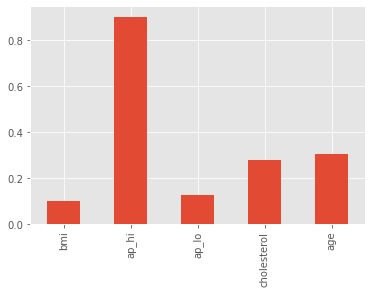

In [42]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(fav_lr_clf.named_steps['classifier'].coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

# Tree Based Models

For our tree-based analysis, we are first looking at what an individual decision tree would do for predicting a cardiac event. We use the single tree as a simplified example for what could be in the Random Forest model, for the purposes of interpretation and visualization. Then we will run a Random Forest Model, tuning it for the best parameters.

## Data Preparation

### Variable Selection

For our tree-based models, we prepared our data with all of the variables except height and weight.  Height and weight were combined into BMI. We did not one-hot encode the categorical variables because having denser data allows the trees to pick the best splits of the variables rather than having each category be a feature.

In [21]:
X = df[['age', 'gender','ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke','alco','active', 'bmi']].values

#our target variable is cardio
y = df['cardio'].values


### Scaling

We do not use scaling for the tree based models because it is not necessary for these algorithms, and scaling would make the model less interpretable.

## Base model: stump

For a baseline for comparison, we start by seeing how a tree with just one split can perform. It achieves F1 score of .718.

In [23]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

In [24]:
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    f1 = mt.f1_score(y_test, y_hat)
    print(f1)

0.7229000884173299
0.7145922746781117
0.7134222222222222


### Feature Importance

In the stump with just one variable with the most predictive power, we see ap_hi, which is systolic blood pressure, which is expected, as we saw it had the most correlation with our target in our earlier analysis.

In [46]:
clf.feature_importances_

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
pd.Series(clf.feature_importances_, index=df[['age', 'gender','ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke','alco','active', 'bmi']].columns)

age            0.0
gender         0.0
ap_hi          1.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
bmi            0.0
dtype: float64

## Single Decision Tree Best Tree Depth

Knowing that the Random Forest model we plan to make is made up of many decision trees, for the sake of understanding and visualizing what will go on under the hood of our future Random Forest model, we made a single decision tree. The single decision tree has a best max depth of 5 and an F1 score of .75.

In [48]:
#first pass over finding best tree depth
param_grid = [
  {'max_depth': [1, 2, 5, 7, 10, 20]}
 ]

dtree = DecisionTreeClassifier(min_samples_leaf=1)
clf = GridSearchCV(dtree, param_grid, scoring="f1",cv=cv_object)
clf.fit(X, y)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.745051 using {'max_depth': 7}
0.716589 (0.004237) with: {'max_depth': 1}
0.716589 (0.004237) with: {'max_depth': 2}
0.742457 (0.004523) with: {'max_depth': 5}
0.745051 (0.005495) with: {'max_depth': 7}
0.738595 (0.002587) with: {'max_depth': 10}
0.698398 (0.004169) with: {'max_depth': 20}


In [49]:
dtree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=5)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

## Visualizing the Tree

This is a visualization of a decision tree, likely to be one of many of the trees in the Random Forest model. The first split it chooses is on X[2] <= 129.5, which is a split on the ap_hi variable. It intuitively makes sense that ap_hi makes the first split, since we've found ap_hi to be the most important variable for predicting cardio previously. Based on conditions such as these, we can follow the flow down the tree to get nodes that lean orange, which would predict not having cardiac disease, and nodes that lean blue, which would predict a cardiac disease.

[Text(809.1, 498.3, 'X[2] <= 129.5\ngini = 0.493\nsamples = 42442\nvalue = [18711, 23731]'),
 Text(404.55, 407.70000000000005, 'X[0] <= 20128.5\ngini = 0.46\nsamples = 21386\nvalue = [13709, 7677]'),
 Text(202.275, 317.1, 'X[4] <= 2.5\ngini = 0.401\nsamples = 12503\nvalue = [9027, 3476]'),
 Text(101.1375, 226.5, 'X[0] <= 16100.5\ngini = 0.385\nsamples = 11893\nvalue = [8795, 3098]'),
 Text(50.56875, 135.89999999999998, 'X[4] <= 1.5\ngini = 0.287\nsamples = 2825\nvalue = [2335, 490]'),
 Text(25.284375, 45.299999999999955, 'gini = 0.269\nsamples = 2577\nvalue = [2165, 412]'),
 Text(75.853125, 45.299999999999955, 'gini = 0.431\nsamples = 248\nvalue = [170, 78]'),
 Text(151.70625, 135.89999999999998, 'X[9] <= 27.886\ngini = 0.41\nsamples = 9068\nvalue = [6460, 2608]'),
 Text(126.421875, 45.299999999999955, 'gini = 0.388\nsamples = 6383\nvalue = [4701, 1682]'),
 Text(176.990625, 45.299999999999955, 'gini = 0.452\nsamples = 2685\nvalue = [1759, 926]'),
 Text(303.4125, 226.5, 'X[5] <= 2.5\ngi

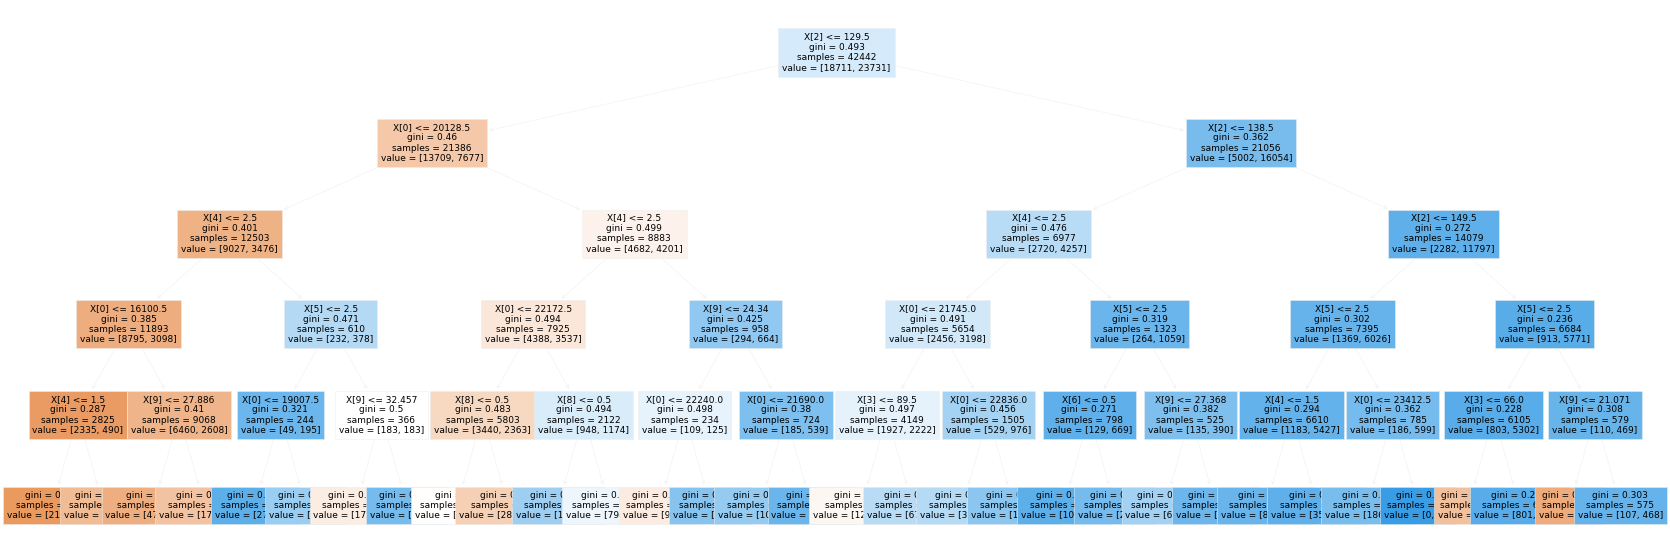

In [50]:
fig, ax = plt.subplots(figsize=(29, 10))  # whatever size you want
tree.plot_tree(dtree, ax=ax, filled=True,  fontsize=9)

##  Random Forest model


### Hyperparameter Tuning

The random forest model has many hyperparameters that can be tuned, and to grid search in detail would take a long time, so we do a randomized search.

Random Forest Hyperparameters are:


**n_estimator:**
The number of trees in the forest. The Random Forest algorithm is the grouping of the trees. More trees should be able to produce a more generalized result (The higher the number, the better). However, by choosing more trees, the Random Forest model's time and complexity also increase. The performance of the model sharply increases and then stagnates at a certain level. Therefore, choosing a large number of estimators in a random forest model is not the best idea. Choosing a lower number will not degrade the model without consuming a lot of processing power.

**max_feature:**
The maximum features provided to each tree in a random forest. In random forest f1, value improvements are drastic initially, then start stagnating or even degrading, this is an indication of overfitting. By increasing the number of features, processing speed will decrease. max_features is one of the more complicated parameters as it is dependent on the type as well.
integer: It is directly a number float: It is a percentage auto or sqrt: It is set to the square root of the number of features (sqrt(n_feature)) Log2: is defined as Log2(n_features)

**max_depth:**
max-depth selects the depth of your tree. It is critical to set the depth. Else model runs into the risk of overfitting.

**min_samples_split:**  is the minimum number of samples to to split a node

**min_samples_leaf:**  is the minimum number of samples to be at a leaf node

**bootstrap:** determines how the points are resampled

In [51]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt', 8]
max_depth = [4, 8, 12]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 60, cv = cv_object, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 88.4min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
                   estimator=RandomForestClassifier(), n_iter=60, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 8, 12, None],
                                        'max_features': ['log2', 'sqrt', 8],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [53]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=12, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400)

In [25]:
rf_clf = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400)

rf_clf.fit(X_train, y_train)
fav_rf_clf = rf_clf #saving this for model comparison later

### Predictions and Evaluation

Here, we evaluate our model. It has an F1 score of .72, precision of .75, and recall of .68

In [27]:

yhat = rf_clf.predict(X_test)

rf_f1 = mt.f1_score(y_test, y_hat)
rf_precision = mt.precision_score(y_test, y_hat)
rf_recall = mt.recall_score(y_test, y_hat)
rf_acc = mt.accuracy_score(y_test, y_hat)

print('Random Forest Metrics: f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (rf_f1, rf_precision, rf_recall, rf_acc))

Random Forest Metrics: f1=0.713, precision=0.758, recall=0.674, accuracy=0.696


The confusion matrix shows dark blue on the diagonal, indicating that the model predicts correctly much more often than it predicts incorrectly. The model has a .3 false negative rate and .26 false positive rate.



Confusion matrix, without normalization
[[3251 1444]
 [1475 4441]]
Normalized confusion matrix
[[0.69243876 0.30756124]
 [0.24932387 0.75067613]]


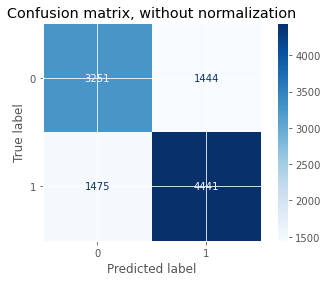

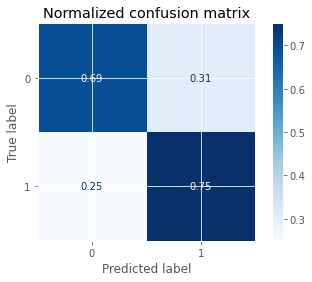

In [56]:
classifier = rf_clf
class_names = [0, 1]
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()




## Feature Importances

The Random Forest model takes many of the features into account. In order of importance, we have ap_hi, age, ap_lo, bmi, cholesterol, gluc, active, and then the rest are all relatively trivial. The order of our feature importances makes a lot of intuitive sense, as we know that high blood pressure is directly related to having a heart attack, so that would be the variable of most importance. Next, age being the second most important feature tells us that getting older strongly increases a person's risk of heart disease. Next, obesity, and high cholesterol are also related to heart disease, but since they are lower in feature importance than the others, it could be that they are less directly related than blood pressure.

In [57]:
rf_clf.feature_importances_

array([0.17667039, 0.01039092, 0.41657053, 0.15759856, 0.08236044,
       0.01776985, 0.00775787, 0.00703358, 0.01442387, 0.10942397])

In [58]:
features = pd.Series(rf_clf.feature_importances_, index=df[['age', 'gender','ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke','alco','active', 'bmi']].columns)
features.plot(kind='bar')
plt.show()

## KNN for predicting cardiac events

## Data Preparation

### Variable Selection

Knowing that KNN is highly affected by noise variables, we select only the 5 variables that we know have the most association with the target.

In [98]:
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']]
y = df['cardio']

### Scaling

Scaling is very important to KNN models because the calculation of distance will be negatively affected by large differences in scale between the variables. Therefore, we plan to scale our features before using them in the KNN model.

### Picking K number of neighbors for KNN model
The following was run to pick the optimal number of "K" neighbors to use for our KNN Model.   The Optimal value is around 39.

We use just one 80/20 split here instead of shuffling 3 times to find the K, for convenience, because this is not yet our final hyperparameter tuning. In the grid search later, we will continue with the 3 shuffle split repetitions.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.20)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

error_rate = []
K_array = []
for K in [3, 11, 25, 30, 35, 39, 42, 45, 51, 63, 75, 125, 151, 200, 501, 600]:
    
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test))
    K_array.append(K)
    f1 = mt.f1_score(y_test, pred)
    print("K:", K, "has f1 score:", f1)

K: 3 has f1 score: 0.705647508941196
K: 11 has f1 score: 0.7360948722231501
K: 25 has f1 score: 0.7425642749117795
K: 30 has f1 score: 0.7371024132344164
K: 35 has f1 score: 0.7426743011114855
K: 39 has f1 score: 0.7448670481319422
K: 42 has f1 score: 0.7405386975792704
K: 45 has f1 score: 0.7431463517503163
K: 51 has f1 score: 0.7443114781729311
K: 63 has f1 score: 0.7441037735849058
K: 75 has f1 score: 0.7447564276048715
K: 125 has f1 score: 0.746761493522987
K: 151 has f1 score: 0.7467186044542298
K: 200 has f1 score: 0.7471049046321525
K: 501 has f1 score: 0.7462737415893025
K: 600 has f1 score: 0.7454793585806891


The following shows the error rates for the different K Values we looked at. The error rate looks to be least at K=200, but we will not necessarily use this K for our model because our evaluation metric is F1 score. When we grid search we will optimize K and other parameters for F1 score.

In [100]:
plt.figure(figsize=(10,9))
plt.plot(K_array,error_rate,color='black', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Error Rate')

### Grid Search Options for KNN Model

The following was run to pick optimal values for weights, algorithm, leaf_size and p for our KNN Model. We set the number of neighbors at 39 based on our analysis above. This grid search uses the 80/20 shuffle split cross validation method.

The KNN hyperparameters are:

**n_neighbors:** this defines how many neighbors should be taken into account to predict the new values.

**Weight:** this parameter can be set to either 'uniform' where each neighbor within the boundary carries the same weight, or 'distance' where closer points will be more heavily weighted toward the decision. Note that when weights = 'distance,' the class with the highest number in the boundary may not "win the vote".

**algorithm:** This is the type of tree used to find the neighboring points

**leaf_size:** The leaf size passed to kdtree or ball tree

**p:** The power for the Minkowski metric, to compute distances of neighbors. 1=manhattan, 2=euclidean.

In [101]:
grid = {'classifier__n_neighbors' : [39],
       'classifier__weights': ['uniform', 'distance'],
       'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],
       'classifier__leaf_size': [5, 30, 50, 75],
       'classifier__p': [1, 2] #1=manhattan, 2=euclidian
       }

knn_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())])
knn_grid = GridSearchCV(estimator=knn_clf, param_grid = grid, cv = cv_object, scoring='f1')

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__algorithm': ['auto', 'ball_tree',
                                                   'kd_tree'],
                         'classifier__leaf_size': [5, 30, 50, 75],
                         'classifier__n_neighbors': [39],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1')

In [29]:
print(knn_grid.best_estimator_)

fav_knn_clf = knn_grid.best_estimator_

# This was the result of the best estimator. Run this if you don't have time to run the grid search
#fav_knn_clf = Pipeline(steps=[('scaler', StandardScaler()),
#                ('classifier',
#                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=5,
#                                      n_neighbors=39))])
#fav_knn_clf.fit(X_train, y_train)

In [31]:
print(fav_knn_clf)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=5,
                                      n_neighbors=39))])

### KNN Model Evaluation

Our KNN model has a F1 score of .745, precision of .745, and recall of .744.

In [32]:
y_hat = fav_knn_clf.predict(X_test)
knn_f1 = mt.f1_score(y_test, y_hat)
knn_precision = mt.precision_score(y_test, y_hat)
knn_recall = mt.recall_score(y_test, y_hat)
knn_acc = mt.accuracy_score(y_test, y_hat)

print('KNN Metrics: f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (knn_f1, knn_precision, knn_recall, knn_acc))

KNN Metrics: f1=0.744, precision=0.749, recall=0.739, accuracy=0.715


# Create a confusion matrix and classification report.

The confusion matrix shows that the diagonals are very dark blue compared to the off diagonals, which means our model predicts correctly most of the time. The true positive rate is .71, and the true negative rate is .73.

Confusion matrix, without normalization
[[3283 1348]
 [1635 4345]]
Normalized confusion matrix
[[0.70891816 0.29108184]
 [0.27341137 0.72658863]]


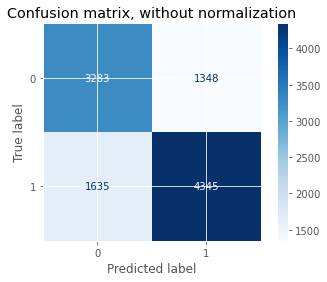

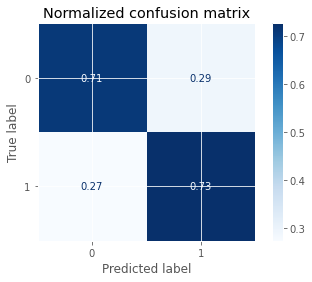

In [63]:
classifier = knn
class_names = [0, 1]
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()



## PCA: Dimensionality reduction

### Extra work
This is some extra analysis that we put in to see what the KNN model would look like if we ran it against Principal Components.  We came up with the idea from our Exploratory Data Analysis in the Lab 1.

In our EDA, we noticed that PCA created a good split between cardio and non-cardio in the first two principal components. Therefore, we decided to try Principal Components Analysis in order to reduce the dimensions of our data.   It did not improve our KNN model, so we feel the KNN model is better using the scaled variables than using the principal components.

In [6]:
#scale the data
from sklearn.preprocessing import StandardScaler

df_continuous = df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
scaler = StandardScaler()
scaler.fit(df_continuous)
df_scaled = pd.DataFrame(scaler.transform(df_continuous))

#PCA with scaled data
from sklearn.decomposition import PCA

X = df_scaled
y = df.cardio

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

print("Percent Variance Explained")
print(pca.explained_variance_ratio_)

df_pca = pd.DataFrame(X_pca)

df_pca.head()

Percent Variance Explained
[0.36093009 0.2506096 ]


0         1
0  1.176529 -0.734042
1 -1.584512 -0.234259
2  2.205832  0.649648
3 -0.905054 -1.965919
4  0.215489 -0.462718

### PCA Scatterplot

This scatterplot shows that the first two principal components show a clear split on those with cardiac disease and those without.   This is what made us think that perhaps we could look at what the KNN on the principal components would look like.

In [7]:
#plot of PC1 and PC2 colored by cardio
ax = df_pca.plot.scatter(0, 1, c=y, colormap='autumn')
ax.set_title('PC1 vs PC2 by Cardio')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

Text(0, 0.5, 'PC2')

### Finding K for the PCA KNN

We re-did the loop through the valid K values for Principal Components.  In this case, it looks like a K-Value of around 51 is optimal.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y,
                                                    test_size=0.20)

In [1]:
###knn.fit(X_train,y_train)
# think we can take this out since there's more work below

In [9]:
for K in [3, 5, 9, 17, 33, 51, 151, 501, 1001]:
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    f1 = mt.f1_score(y_test, pred)
    print("K:", K)
    print(f1)

K: 3
0.6773978315262719
K: 5
0.7010617120106172
K: 9
0.7126744088896316
K: 17
0.7243143504151639
K: 33
0.7302309897150565
K: 51
0.7333783327708404
K: 151
0.7324445953978093
K: 501
0.734237693029605
K: 1001
0.7327141382868936


The F1 Score for the KNN with default parameters was not an improvement over the KNN model that used the real variables.  However, to give it the same chance, we are using the same grid logic that was used for the KNN model above.  Since this still didn't improve the F1 Score and it would be very hard to explain to clients, we do not think using this KNN model on Principal components is valuable.

In [23]:
grid = {'classifier__n_neighbors' : [51],
       'classifier__weights': ['uniform', 'distance'],
       'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],
       'classifier__leaf_size': [5, 30, 50, 75],
       'classifier__p': [1, 2] #1=manhattan, 2=euclidian
       }

pca_knn_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())])
pca_knn_grid = GridSearchCV(estimator=pca_knn_clf, param_grid = grid, cv = cv_object, scoring='f1')

pca_knn_grid.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                

In [24]:
print(pca_knn_grid.best_estimator_)

pca_knn = pca_knn_grid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=5,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=51, p=2,
                                      weights='uniform'))],
         verbose=False)


Show the metrics for the PCA KNN model with Neighbors = 51.    This analysis would be very difficult to explain to the clients, and the F1 score is not any higher than it would be without the Principal Components, so it would not be a recommended model.

In [25]:
y_hat = pca_knn.predict(X_test)
knn_f1 = mt.f1_score(y_test, y_hat)
knn_precision = mt.precision_score(y_test, y_hat)
knn_recall = mt.recall_score(y_test, y_hat)
print("PCA KNN F1:", knn_f1, "PCA KNN precision:", knn_precision, "PCA KNN Recall:" , knn_recall)

PCA KNN F1: 0.732563042928228 PCA KNN precision: 0.7363513055272974 PCA KNN Recall: 0.7288135593220338


# Cardio Models Comparison

A recap of the F1, precision, and recall of the three models are shown here. Logistic regression has the highest F1 and recall, random forest has the lowest F1 and recall but the highest precision, and KNN is middle of the road.

In [42]:

print('Logistic Regression Metrics: f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (lr_f1, lr_precision, lr_recall, lr_acc))
print('Random Forest Metrics: f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (rf_f1, rf_precision, rf_recall, rf_acc))
print('KNN Metrics: f1=%.3f, precision=%.3f, recall=%.3f, accuracy=%.3f' % (knn_f1, knn_precision, knn_recall, knn_acc))

Logistic Regression Metrics: f1=0.759, precision=0.694, recall=0.836, accuracy=0.702
Random Forest Metrics: f1=0.713, precision=0.758, recall=0.674, accuracy=0.696
KNN Metrics: f1=0.744, precision=0.749, recall=0.739, accuracy=0.715


## Statistical Comparison

To compare whether or not the 3 models are statistically different, we run 10 shuffle split cross validations to get a sense of the range of each model's f1 scores. Then we perform an ANOVA to see if the difference in the distributions of their f1 scores is significant.

In [19]:
clf1 = fav_lr_clf
clf2 = fav_rf_clf
clf3 = fav_knn_clf

from sklearn.model_selection import cross_val_score

cv_object = ShuffleSplit(n_splits=10,
                         test_size  = 0.2)
y = df['cardio'].values

f1_lr = []
f1_rf = []
f1_knn = []
for train_indices, test_indices in cv_object.split(X, y):
    #lr
    X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    clf1.fit(X_train, y_train)
    y_prob = clf1.predict_proba(X_test)[:,1]
    y_hat = list(map(lambda y_prob: 1 if y_prob > .4 else 0, y_prob))
    f1 = mt.f1_score(y_test, y_hat)
    f1_lr.append(f1)
    
    #rf
    X = df[['age','bmi','cholesterol','gluc','smoke','alco','active']].values 
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    clf2.fit(X_train, y_train)
    y_hat = clf2.predict(X_test)
    f1 = mt.f1_score(y_test, y_hat)
    f1_rf.append(f1)
    
    #knn
    X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    clf3.fit(X_train, y_train)
    y_hat = clf3.predict(X_test)
    f1 = mt.f1_score(y_test, y_hat)
    f1_knn.append(f1)



In [21]:
print("LR: ", f1_lr)
print("RF: ", f1_rf)
print("KNN: ", f1_knn)

LR:  [0.7635944700460829, 0.7574822585621721, 0.7597208374875375, 0.7655399708745306, 0.7630651340996168, 0.754808066651094, 0.763067004374856, 0.7621824879134371, 0.7626231527093595, 0.7601078167115902]
RF:  [0.6978770595690748, 0.6917316938598564, 0.6827991113932085, 0.6858651307895368, 0.6934832528307863, 0.6838554216867471, 0.6879194630872483, 0.6847164370394104, 0.6899175649968294, 0.6857644430258538]
KNN:  [0.7449126066030566, 0.7411824842392231, 0.7406716417910448, 0.7479134730028957, 0.743238674780257, 0.741001028453891, 0.7460937499999999, 0.7435310087384407, 0.742754552449346, 0.7424049017104927]


The arrays of the 10 F1 scores for each model are shown here. From a glance, it is clear that the distributions are different. The LR ranges from .75-.76, the RF ranges from .68-.69, and the KNN ranges from .74-.74.

We proceed to do an ANOVA one way F test to formally show that there is significant difference between the models. The ANOVA has an F statistic of 1110 and a p-value of 1.18e-26, which is very significant.

In [22]:
from scipy.stats import f_oneway

f_oneway(f1_lr, f1_rf, f1_knn)


F_onewayResult(statistic=1110.5028042903646, pvalue=1.1861675678568923e-26)

In [27]:
data = [f1_lr, f1_rf, f1_knn]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_title("F1 Score Ranges of Models")
plt.xticks([1, 2, 3], ['LR', 'RF', 'KNN'])
plt.show()

Comparing the Logistic Regression, Random Forest, and KNN models, we find that the Logistic Regression has the best f1 score, the KNN has the next best, and the Random Forest has the lowest. Additional advantages and disadvantages of the models are discussed below. 

## Advantages and Disadvantages

### Random Forest

#### Pros
Our random forest model had the highest precision of the three. The Random Forest algorithm maintains good accuracy even if a
large proportion of the data is missing. 
This could be valuable for us if all the patient’s data is not
available.
In general, random forest models generalize well and
overcome a problem with overfitting by averaging or combining the results of
different decision trees.  It is a
very flexible model that possesses very high accuracy rates.   The random forest maintains good accuracy without
scaling the data. 

#### Cons:

Complexity is the main disadvantage of Random forest
algorithms.  This would mean that
it would be difficult to interpret to a patient why they were flagged by the model. More
computational resources are required to implement Random Forest algorithm and the
prediction process using random forests is very time-consuming in comparison
with other algorithms.  This
however, would probably not be a huge issue since we don’t foresee this model being
run against a large volume of patient data at one time.

### KNN:

#### Pros:

The training phase of K-nearest neighbor classification is
much faster compared to other classification algorithms.   This could be valuable if we want to re-train
periodically on new patient data.  KNN
can be useful in case of nonlinearly separable data. For
patient data, it is comparing data to similar patients, which could be a valuable
way to classify a patient’s condition.

#### Cons:

The testing phase of K-nearest neighbor classification is
slower and costlier in terms of time and memory. It requires large memory for
storing the entire training dataset for prediction. KNN requires scaling of
data because KNN calcluates distance between two data points to find
nearest neighbors. Often, measures of distance are sensitive to magnitudes and features
with high magnitudes will weigh more than features with low magnitudes. KNN is also
not suitable for large dimensional data, but we do not have a large number of
predictors in our data, so this may not be an issue for us.
KNN prediction time is slow, which would only become an issue if we need to run the model on a very large number of patients.

### Logistic Regression
#### Pros:
The main advantage of our logistic regression model is that it clearly had the highest f1 score and recall. Considering the importance of recall in the healthcare scenario, this is a major pro. Since we scaled the data, we don't have the advantage of being able to interpret the effect of the variable coefficients, but we do have the weights indicating the importance of the features.  For example, systolic blood
pressure has the highest weight, so we can tell a patient that the reason he/she was flagged was likely due to high blood pressure.   In general, Logistic Regression performs
well when the dataset is linearly separable. 
From our PCA analysis, we discovered that this is the case.  

#### Cons:
One disadvantage of Logistic regression is
that if there are less observations than the number of variables, it should not
be used. This is fine in our case because we have many observations to use for training. Another
limitation of Logistic Regression is the assumption of linearity between the
dependent variable and the independent variables. 

# Cardiac Event Model Deployment

The model for predicting cardiac events would be used as a tool that is run periodically over a medical office's patient base, to identify patients who may need additional medical testing in order to determine if conditions that lead to an increased risk of a cardiac event should be treated.  For example, if patients are flagged by this model, the medical office can reach out to them to schedule additional testing to be performed to identify if they need treatment for high blood pressure, high cholesterol or obesity. This model would not replace the patient’s doctor reviewing their test results with them individually, but it is a way for the medical office to review all of their patients' conditions together at one time.

The collection of this data would be done a patient’s doctor office or hospital visit.  These visits could be a routine physical exam, or any other doctor office visit. Most doctor visits include collecting height, weight and blood pressure data and this data may be collected at a time that the doctor and patient are not even concerned about that patient having a cardiac event.  For example, if a patient breaks their arm, it is likely that their blood pressure would be taken.  It would be entered in the system, but the doctor would not necessarily be looking at the other factors, such as cholesterol. However, once any new data for any of these factors; high blood pressure, cholesterol or BMI is entered into the patient’s record, this model can be executed by the doctor or hospital’s medical office staff.  At that point, they may notice that the combination of factors, caused the model to flag them as a patient who is a candidate for further medical testing.   In order to identify patients individually, the system would need to add the patient id number to the patient data.

We can measure the value of using the model by tracking the number of patients who received additional care due to being flagged by this model.